In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *

## Testing Approximate Reference

In [2]:
n = 50
p = 5
X = np.random.normal(size=(n, p))
a = 1
b = 1

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 3
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=5, min_proportion=0.)
reg_tree.fit(X, y, sd = noise_sd)

In [3]:
reg_tree.fit(X, y, sd = noise_sd)

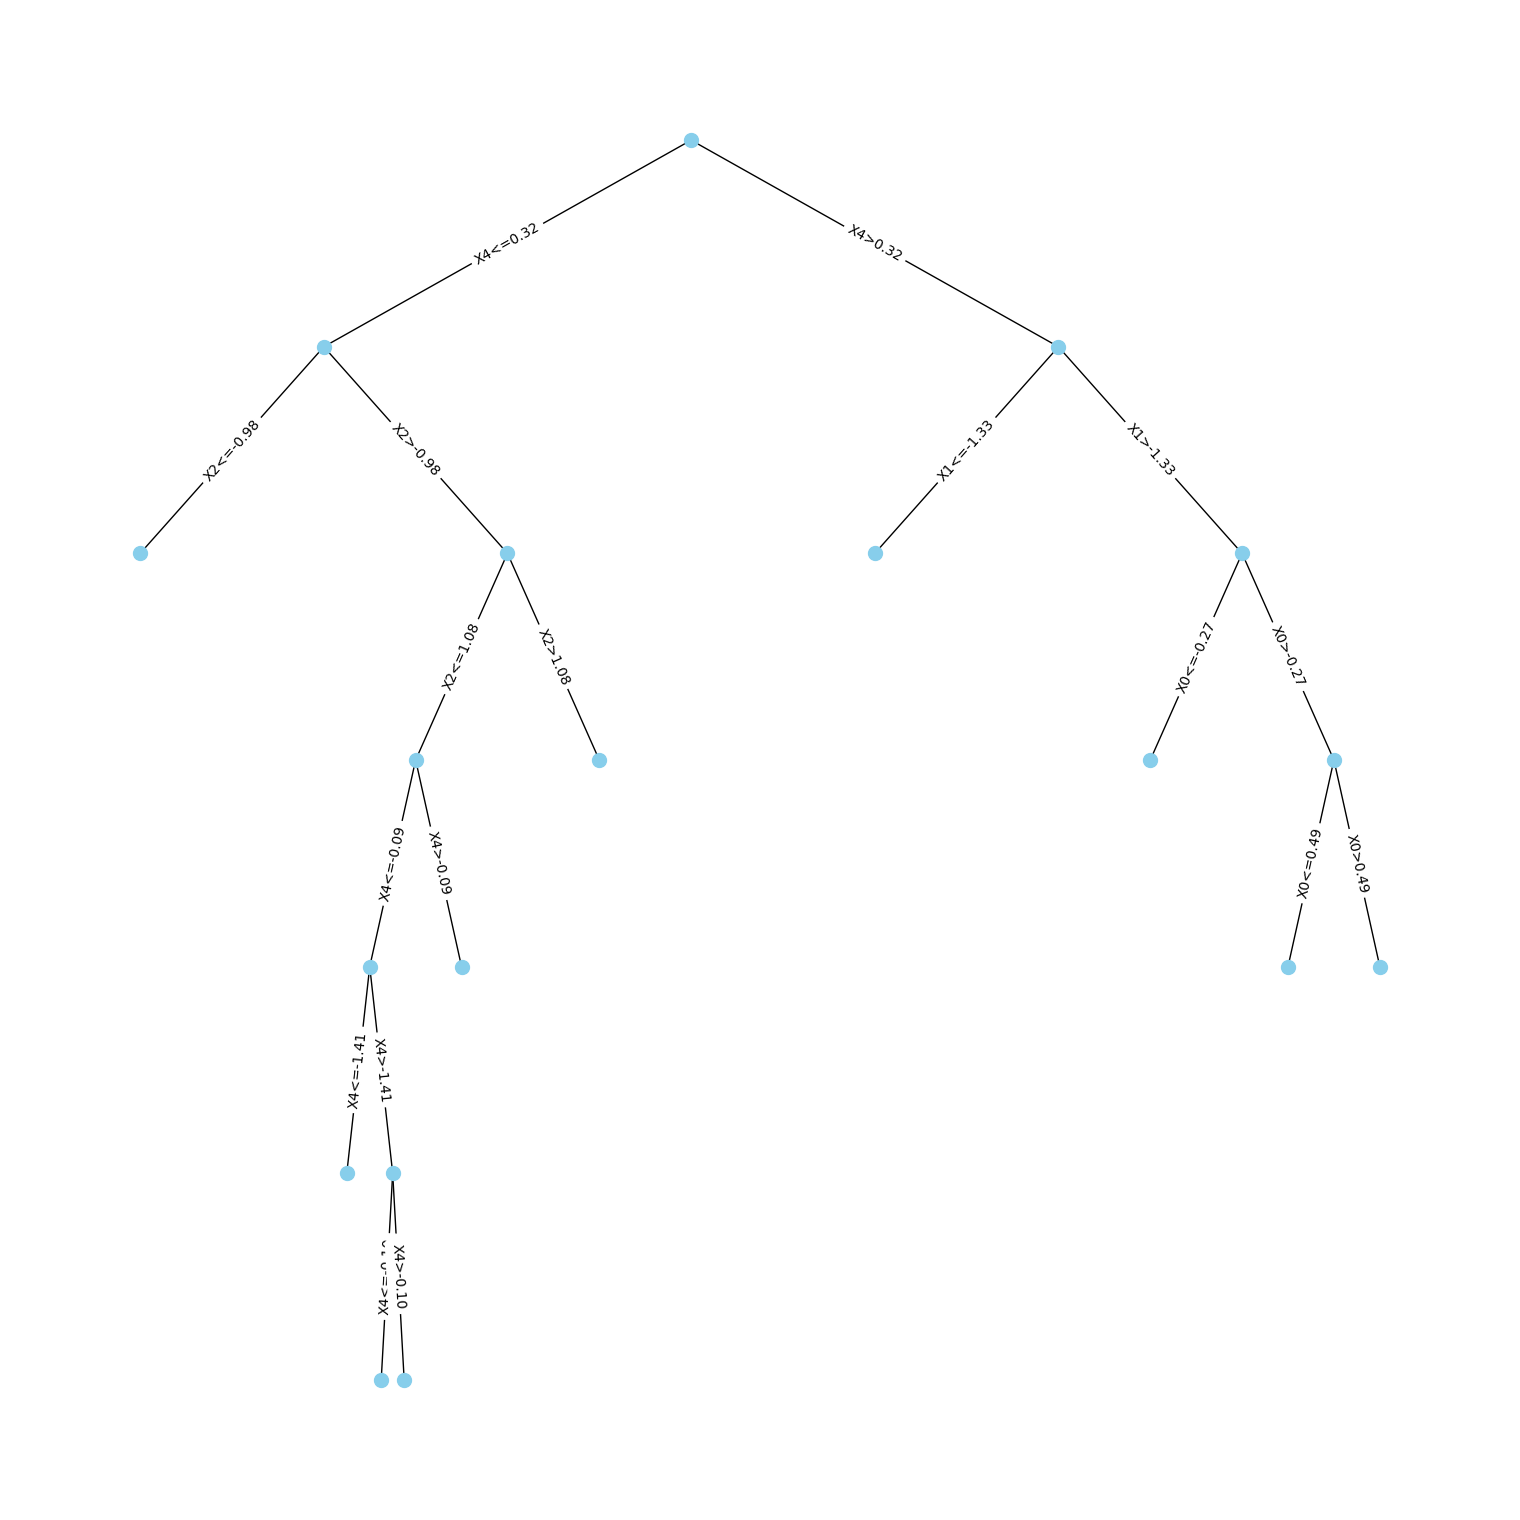

In [4]:
draw_tree(reg_tree.root)

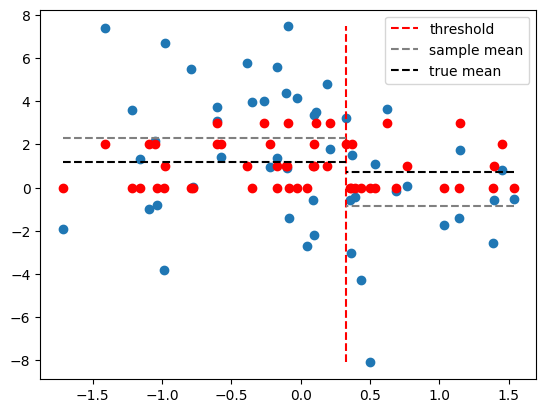

In [5]:
print_split_info(reg_tree.root, X, y, mu)

In [6]:
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
    reg_tree.condl_split_inference(node=reg_tree.root, 
                                   ngrid=10000,
                                   ncoarse=200,
                                   grid_width=15,
                                   reduced_dim=1,
                                   sd=sd))

In [7]:
naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                     null=norm_contrast.dot(mu))
print(naive_pivot)

0.0013949155931071058


In [8]:
print(obs_tar)

3.521396266540265


In [9]:
print(norm_contrast.dot(mu))

0.5314024762836138


In [10]:
print(norm_contrast.dot(mu))

0.5314024762836138


In [11]:
mu

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 3, 0, 1, 2, 1,
       2, 0, 1, 3, 3, 0, 0, 3, 1, 3, 3, 3, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0,
       2, 1, 0, 2, 0, 2])

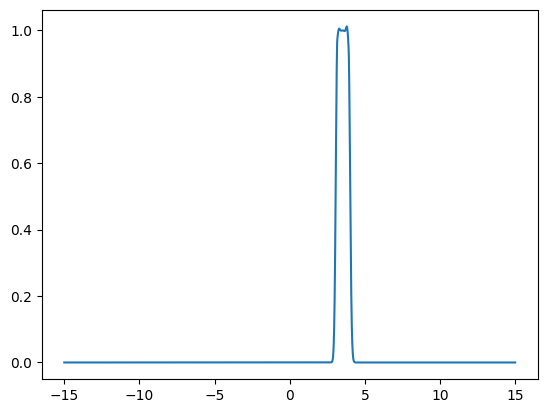

In [12]:
import matplotlib.pyplot as plt
x = np.linspace(-15, 15, 10000)
plt.plot(x, np.exp(sel_probs))

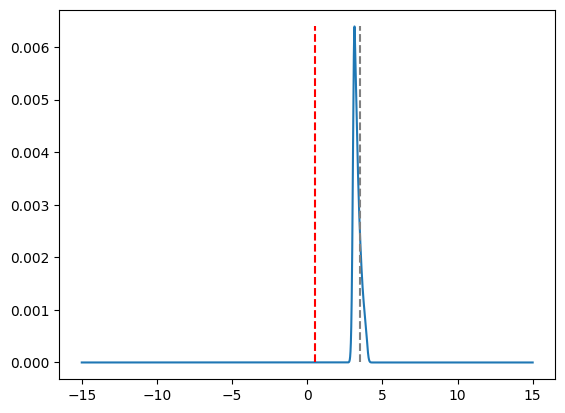

In [13]:
plt.plot(x, dist.pdf(theta=norm_contrast.dot(mu)))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [14]:
dist.ccdf(theta=norm_contrast.dot(mu), x=obs_tar)

np.float64(0.1986489655464567)

In [15]:
pval

np.float64(0.16040764387125675)

In [434]:
(x > obs_tar).sum()

np.int64(3745)

In [31]:
(pivot_f, condl_density_f, contrast_f, norm_contrast_f,
 observed_target_f, logWeights_f, sel_probs_f) \
    = reg_tree.split_inference(node=reg_tree.root, 
                               ngrid=10000,
                               ncoarse=200,
                               grid_width=15,
                               sd=sd)

barr 100.25118504169225
obj -4107.099762258529
conjugate norm: 85.06781842032906
barr 100.02975390349509
obj -4248.007964066266
conjugate norm: 84.63533119990096
barr 99.28574982525294
obj -4192.624775098404
conjugate norm: 84.20453173539086
barr 99.89326146496676
obj -4144.494980921283
conjugate norm: 83.77541668058835
barr 99.87649288539562
obj -4003.687813627406
conjugate norm: 83.34798272544002
barr 100.60842183335107
obj -3903.6942568953773
conjugate norm: 82.92222659765665
barr 98.97410812979025
obj -4020.5092178290583
conjugate norm: 82.49814506435781
barr 98.85392208820386
obj -3977.1399396901097
conjugate norm: 82.07573493375413
barr 99.7926562838905
obj -3964.1594753805684
conjugate norm: 81.65499305686835
barr 96.90435003404014
obj -4053.211343457451
conjugate norm: 81.23591632929578
barr 99.40332675176921
obj -3947.2492709771573
conjugate norm: 80.81850169300454
barr 98.90335887058697
obj -3932.9214281724453
conjugate norm: 80.40274613817708
barr 101.9697513970111
obj -3783

KeyboardInterrupt: 

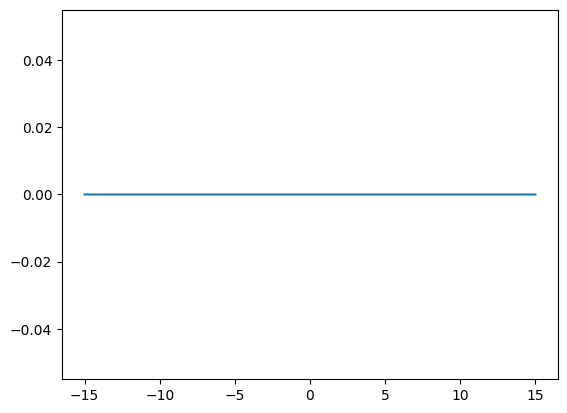

In [60]:
plt.plot(x, np.exp(sel_probs))

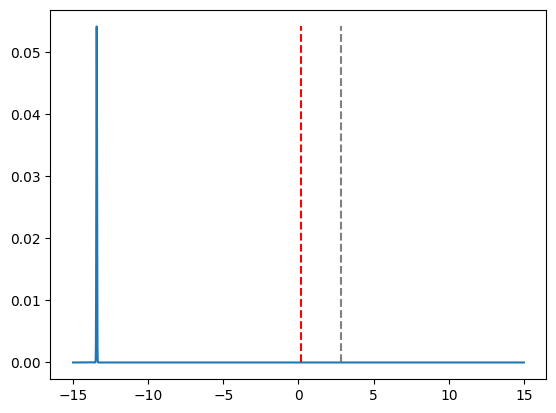

In [61]:
plt.plot(x, condl_density_f.pdf(theta=0))
plt.vlines(obs_tar, ymin=0, ymax=np.max(condl_density_f.pdf(theta=0)),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(condl_density_f.pdf(theta=0)),
           linestyles='--', colors='red')

# Replicate Tree Value Simulations

In [19]:
X = np.random.normal(size=(100, 10))
a = 1
b = 1
mu = b* ( (X[:,0] <= 0) * (1 + a * (X[:,1] > 0) + (X[:,2] * X[:,1] <= 0)) )
y = mu + np.random.normal(size=(100,), scale=1)

In [31]:
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=10)
reg_tree.fit(X, y)

# Make predictions
predictions = reg_tree.predict(X)
#print(predictions)
reg_tree.print_branches()

 j: 0
 threshold: -0.026246156794562686
 left:
	 j: 8
	 threshold: -0.47691162512272384
	 left:
		 j: 6
		 threshold: -1.882026910030391
		 left:
		 right:
			 j: 5
			 threshold: -0.7006531475942253
			 left:
			 right:
	 right:
		 j: 1
		 threshold: -0.046286560689003074
		 left:
			 j: 4
			 threshold: -0.6951223438765441
			 left:
			 right:
				 j: 1
				 threshold: -1.7342866936815915
				 left:
				 right:
					 j: 9
					 threshold: -0.2666871517794296
					 left:
					 right:
		 right:
			 j: 1
			 threshold: 1.3119538813916485
			 left:
				 j: 5
				 threshold: 0.020045901693990745
				 left:
				 right:
			 right:
 right:
	 j: 6
	 threshold: 1.1256570637586534
	 left:
		 j: 4
		 threshold: 1.461856376611065
		 left:
			 j: 6
			 threshold: -1.7952845350243212
			 left:
			 right:
				 j: 4
				 threshold: -0.4259380811250433
				 left:
					 j: 1
					 threshold: 1.6819463364634613
					 left:
						 j: 8
						 threshold: -0.3066579992144446
						 left:
						 right:
				

# A Toy Example Showing the Symmetry in Selection Probabilities

Suppose $n=4$ and we want to divide a dataset based on one covariate $X$ where $X_1, X_2 \leq X_3, X_4$.

In [291]:
eta = np.array([-0.5, -0.5, 0.5,0.5])

In [298]:
P_perp = np.eye(4) - np.linalg.outer(eta, eta)/(np.linalg.norm(eta)**2)

In [299]:
Y = np.array([-5.5, -4.5, 1.5, 0.5])
mu = np.array([-5, -5, 1, 1])

In [300]:
P_perp @ Y

array([-2.5, -1.5, -1.5, -2.5])

In [301]:
reconstructed_Y = np.linalg.outer(eta, eta)/(np.linalg.norm(eta)**2) @ (-Y) + P_perp @ Y

In [302]:
reconstructed_Y

array([ 0.5,  1.5, -4.5, -5.5])

In [303]:
Y

array([-5.5, -4.5,  1.5,  0.5])

This means, in some cases, flipping sign of the inner product $\eta'Y$ will result in a $Y$ with the original left and right node being flipped, but if we calculate the gain, the gain will stay the same as the version using $\eta'Y$.